# DPM1 - Deep Probabilistic Models I

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/deep_probabilistic_models_I/tutorial_1.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/deep_probabilistic_models_I/tutorial_1.ipynb)  
**Recordings:** [Lecture 1.1](https://webcolleges.uva.nl/Mediasite/MyMediasite/presentations/57053ad80d2847888ef9aefcba2574a61d)
 & [Lecture 1.2](https://webcolleges.uva.nl/Mediasite/MyMediasite/presentations/a30fffc800524283809bd69b27a11a351d)  
**Authors**: Wilker Aziz & Bryan Eikema

## 0. General notes
This notebook illustrates the concepts discussed in the module **Deep probabilistic models I** offered within DL2.

The examples in the notebook are based on NLP datasets, but the concepts are general enough that you can apply them in any domain. At the end of the notebook, we invite you to try your favourite dataset (as long as you can design an encoder for the data type you are interested in, transferring ideas from this notebook should be fairly simple). 

The notebook starts with modelling univariate response variables conditionally, given a high-dimensional and structured input. We look into a nominal response variable and then into a numerical one. Next, we look into a structured response variable. 

### 0.1 ILOs

* Prescribe joint distributions using PyTorch
* Estimate the parameters of the model via maximum likelihood estimation
* Implement a decision rule



### 0.2 Setting up

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import random
import numpy as np
import torch

try:
    import nltk
    import sklearn
except ModuleNotFoundError: # Install nltk and sklearn if necessary
    !pip install --quiet nltk, sklearn
    import nltk

def seed_all(seed=42):    
    np.random.seed(seed)
    random.seed(seed)    
    torch.manual_seed(seed)

seed_all()

## 1. Data

In this tutorial we will design conditional models involving structured data. We use text as an example and design

1. a classifier
2. an ordinal regressor
3. a sequence labeller

At the end of the tutorial you are encouraged to design similar models for a different type of data (for example, consider a different modality of data).


In [2]:
nltk.download('treebank')
nltk.download('brown')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /home/phillip/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /home/phillip/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /home/phillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/phillip/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

### 1.1 Sentiment 

In [3]:
from nltk.corpus import treebank, brown

The `brown` corpus contains texts organized into 15 genres.

In [4]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

The dataset is already preprocessed for us:

In [5]:
print("'fiction' examples")
for i, x in zip(range(3), brown.sents(categories=['fiction'])):
    print(i, x)
print()
print("'religion' examples")
for i, x in zip(range(3), brown.sents(categories=['religion'])):
    print(i, x)
print()
print("'learned' examples")
for i, x in zip(range(3), brown.sents(categories=['learned'])):
    print(i, x)

'fiction' examples
0 ['Thirty-three']
1 ['Scotty', 'did', 'not', 'go', 'back', 'to', 'school', '.']
2 ['His', 'parents', 'talked', 'seriously', 'and', 'lengthily', 'to', 'their', 'own', 'doctor', 'and', 'to', 'a', 'specialist', 'at', 'the', 'University', 'Hospital', '--', 'Mr.', 'McKinley', 'was', 'entitled', 'to', 'a', 'discount', 'for', 'members', 'of', 'his', 'family', '--', 'and', 'it', 'was', 'decided', 'it', 'would', 'be', 'best', 'for', 'him', 'to', 'take', 'the', 'remainder', 'of', 'the', 'term', 'off', ',', 'spend', 'a', 'lot', 'of', 'time', 'in', 'bed', 'and', ',', 'for', 'the', 'rest', ',', 'do', 'pretty', 'much', 'as', 'he', 'chose', '--', 'provided', ',', 'of', 'course', ',', 'he', 'chose', 'to', 'do', 'nothing', 'too', 'exciting', 'or', 'too', 'debilitating', '.']

'religion' examples
0 ['As', 'a', 'result', ',', 'although', 'we', 'still', 'make', 'use', 'of', 'this', 'distinction', ',', 'there', 'is', 'much', 'confusion', 'as', 'to', 'the', 'meaning', 'of', 'the', 'basic

In [6]:
def split_nltk_categorised_corpus(corpus, categories, max_length=30, num_heldout=100):
    """
    Shuffle and split a corpus.
    corpus: a corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    max_length: discard sentences longer than this

    Return: 
        (training word sequences, training tag sequences), 
        (dev word sequences, dev tag sequences), 
        (test word sequences, test tag sequences),         
    """

    sentences = []
    labels = []
    for k, c in enumerate(categories):
        seqs = corpus.sents(categories=[c])
        sentences.extend(seqs)
        labels.extend(len(seqs) * [k])    
    # do not change the seed in here    
    order = np.random.RandomState(42).permutation(np.arange(len(sentences)))   
    shuffled_sentences = [[w for w in sentences[i]] for i in order if len(sentences[i]) <= max_length]    
    shuffled_labels = [labels[i] for i in order if len(sentences[i]) <= max_length] 
    return (shuffled_sentences[2*num_heldout:], shuffled_labels[2*num_heldout:]), (shuffled_sentences[num_heldout:2*num_heldout], shuffled_labels[num_heldout:2*num_heldout]), (shuffled_sentences[:num_heldout], shuffled_labels[:num_heldout])

In [7]:
%%time
(cat_training_x, cat_training_y), (cat_dev_x, cat_dev_y), (cat_test_x, cat_test_y) = split_nltk_categorised_corpus(brown, brown.categories(), num_heldout=1000)
print(f"Number of sentences: training={len(cat_training_x)} dev={len(cat_dev_x)} test={len(cat_test_x)}")

Number of sentences: training=44685 dev=1000 test=1000
CPU times: user 3.07 s, sys: 59.2 ms, total: 3.13 s
Wall time: 3.13 s


In [8]:
len(cat_training_x), len(cat_dev_x), len(cat_test_x)

(44685, 1000, 1000)

In [9]:
cat_training_y[0], cat_training_x[0]

(1,
 ['That',
  'is',
  'why',
  'the',
  'members',
  'of',
  'the',
  'beat',
  'generation',
  'proudly',
  'assume',
  'the',
  'title',
  'of',
  'the',
  'holy',
  'barbarians',
  ';',
  ';'])

### 1.2 Age

[Schler et al (2006)](http://www.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf) collected a dataset of blog posts annotated for the age of the author, we will use a subset of that dataset. The complete dataset can be found 
[on Kaggle](https://www.kaggle.com/rtatman/blog-authorship-corpus).

Warning: we will use this dataset to illustrate Poisson regression, but note that in general age may be a protected attribute in certain applications, and one should carefully consider the implications of designing and deploying an age detection system.

In [10]:
# Download the data
!wget https://surfdrive.surf.nl/files/index.php/s/2xWdFxnewjN9gsq/download -O blog-authorship.json.gz
!gzip -d blog-authorship.json.gz

--2022-04-05 17:42:50--  https://surfdrive.surf.nl/files/index.php/s/2xWdFxnewjN9gsq/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25699440 (25M) [application/gzip]
Saving to: ‘blog-authorship.json.gz’

blog-authorship.jso 100%[===================>]  24.51M  16.1MB/s    in 1.5s    

2022-04-05 17:42:52 (16.1 MB/s) - ‘blog-authorship.json.gz’ saved [25699440/25699440]



In [11]:
import json

with open("blog-authorship.json") as f:
    blog_data = json.load(f)

In [12]:
blog_data.keys()

dict_keys(['source', 'ack', 'subset', 'format', 'training', 'dev', 'test'])

In [13]:
blog_data['source'], blog_data['ack']

('[Blog authorship corpus](https://www.kaggle.com/rtatman/blog-authorship-corpus)',
 '[Schler et al (2006)](http://www.cs.biu.ac.il/~schlerj/schler_springsymp06.pdf)')

We already have a training/dev/test split, each data point is a pair and the text is not preprocessed for us:

In [14]:
len(blog_data['training']), len(blog_data['dev']), len(blog_data['test'])

(200000, 40000, 49174)

In [15]:
blog_data['training'][0]

['I hate exams considering I just failed one. Yippee', 16]

We need to tokenize the data for use in deep learning. We will use the NLTK word tokenizer for this. We also lowercase the inputs and shuffle the training data. This will take some 3 minutes.

In [16]:
%%time
from nltk.tokenize import word_tokenize

# Tokenize and shuffle the data.
order = np.random.RandomState(42).permutation(np.arange(len(blog_data["training"])))   
blog_training_x = [word_tokenize(blog_data["training"][i][0].lower()) for i in order]
blog_training_y = [[blog_data["training"][i][1]] for i in order]
blog_dev_x = [word_tokenize(x[0].lower()) for x in blog_data["dev"]]
blog_dev_y = [[x[1]] for x in blog_data["dev"]]
blog_test_x = [word_tokenize(x[0].lower()) for x in blog_data["test"]]
blog_test_y = [[x[1]] for x in blog_data["test"]]

CPU times: user 1min 10s, sys: 306 ms, total: 1min 11s
Wall time: 1min 11s


In [17]:
# Example pre-processed data point
print(f"input: {blog_training_x[0]}")
print(f"age of author: {blog_training_y[0]}")

input: ['urllink', 'this', 'is', 'my', 'friend', 'sam', '.', 'he', "'s", 'a', 'little', 'weird', '.', 'he', "'s", 'nice', 'though', '.', 'but', 'weird', '.']
age of author: [17]


### 1.3 Syntactic categories

From NLTK, we will also take the `treebank` corpus where words are annotated with their syntactic categories (parts of speech, or POS tags).

The method `tagged_sents` will give us a view of tokenized sentences with their token lag tag annotation:

In [18]:
example = treebank.tagged_sents(tagset='universal')[0]  # 'universal' here refers to the style of tags
example

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

In [19]:
def split_nltk_tagged_corpus(corpus, max_length=30, num_heldout=100):
    """
    Shuffle and split a corpus.
    corpus: a corpus of tagged sequences, each sequence is a pair, each pair is a token and a tag.
    max_length: discard sentences longer than this

    Return: 
        (training word sequences, training tag sequences), 
        (dev word sequences, dev tag sequences), 
        (test word sequences, test tag sequences),         
    """
    tagged_sentences = corpus.tagged_sents(tagset='universal')
    # do not change the seed in here    
    order = np.random.RandomState(42).permutation(np.arange(len(tagged_sentences)))    
    word_sequences = [[w.lower() for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]    
    tag_sequences = [[t for w, t in tagged_sentences[i]] for i in order if len(tagged_sentences[i]) <= max_length]    
    return (word_sequences[2*num_heldout:], tag_sequences[2*num_heldout:]), (word_sequences[num_heldout:2*num_heldout], tag_sequences[num_heldout:2*num_heldout]), (word_sequences[:num_heldout], tag_sequences[:num_heldout])

For `treebank` this will take about 10 seconds.

In [20]:
%%time
(tagger_training_x, tagger_training_y), (tagger_dev_x, tagger_dev_y), (tagger_test_x, tagger_test_y) = split_nltk_tagged_corpus(treebank, num_heldout=100)
print(f"Number of sentences: training={len(tagger_training_x)} dev={len(tagger_dev_x)} test={len(tagger_test_x)}")

Number of sentences: training=2486 dev=100 test=100
CPU times: user 2.38 s, sys: 116 ms, total: 2.5 s
Wall time: 2.52 s


In [21]:
print("# A few training sentences\n")
for n in range(3):    
    print(f"x_{n} = {tagger_training_x[n]}")
    print(f"y_{n} = {tagger_training_y[n]}")
    print()

# A few training sentences

x_0 = ['they', 'know', '0', 'he', 'is', 'generally', 'opposed', 'to', 'cop-killer', 'bullets', ',', 'but', 'that', 'he', 'had', 'some', 'reservations', 'about', 'the', 'language', 'in', 'the', 'legislation', '.', "''"]
y_0 = ['PRON', 'VERB', 'X', 'PRON', 'VERB', 'ADV', 'VERB', 'PRT', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', '.', '.']

x_1 = ['california', "'s", 'education', 'department', 'suspects', 'adult', 'responsibility', 'for', 'erasures', 'at', '40', 'schools', 'that', '*t*-85', 'changed', 'wrong', 'answers', 'to', 'right', 'ones', 'on', 'a', 'statewide', 'test', '.']
y_1 = ['NOUN', 'PRT', 'NOUN', 'NOUN', 'VERB', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NUM', 'NOUN', 'DET', 'X', 'VERB', 'ADJ', 'NOUN', 'PRT', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.']

x_2 = ['the', 'loan', 'may', 'be', 'extended', '*-1', 'by', 'the', 'mcalpine', 'group', 'for', 'an', 'additional', 'year', 'with', 

### 1.4 Vocabulary

As always when dealing with NLP models, we need an object to maintain our vocabulary of known tokens. We will rely on word-tokenization.

Our vocabulary class will maintain the set of known tokens, and a dictionary to convert tokens to codes and codes back to tokens. The class will also take care of some special symbols (e.g., BOS, EOS, UNK, PAD). 

Finally, if later on you test your model on sentences that are not word tokenized, you can use `nlt.tokenize.word_tokenize` or any other tokenizer you like (as long as the level of tokenization is similar to the one you used for training your model.

This class will be used for maintaining both the vocabulary of known tokens and the set of known tags for the tagger data.

In [22]:
import numpy as np
from itertools import chain
from collections import Counter, OrderedDict

class Vocab:

    def __init__(self, corpus: list, min_freq=1):        
        """
        corpus: list of documents, each document is a list of tokens, each token is a string
        min_freq: words that occur less than this value are discarded
        """

        # Count word occurrences
        counter = Counter(chain(*corpus))
        
        # Sort them by frequency
        sorted_by_freq_tuples = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
        
        # Special tokens
        self.pad_token = "-PAD-" # used to fill sequences in a batch to maximum sequence length
        self.bos_token = "-BOS-" # begin of sequence
        self.eos_token = "-EOS-" # end of sequence
        self.unk_token = "-UNK-" # unknown symbol
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3

        self.known_symbols = [self.pad_token, self.bos_token, self.eos_token, self.unk_token]
        self.counts = [0, 0]
        
        # Vocabulary
        self.word2id = OrderedDict()                
        self.word2id[self.pad_token] = self.pad_id        
        self.word2id[self.bos_token] = self.bos_id
        self.word2id[self.eos_token] = self.eos_id
        self.word2id[self.unk_token] = self.unk_id
        self.min_freq = min_freq
        for w, n in sorted_by_freq_tuples: 
            if n >= min_freq: # discard infrequent words
                self.word2id[w] = len(self.known_symbols)
                self.known_symbols.append(w)
                self.counts.append(n)
        
        # Store the counts as well
        self.counts = np.array(self.counts)

    def __len__(self):
        return len(self.known_symbols)

    def __getitem__(self, word: str): 
        """
        Return the id (int) of a word (str)
        """
        return self.word2id.get(word, self.unk_id)

    def encode(self, doc: list, add_bos=False, add_eos=False, pad_right=0):
        """
        Transform a document into a numpy array of integer token identifiers.
        doc: list of tokens, each token is a string
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens 
        
        Return: a list of codes (possibly with BOS and EOS added as well as padding)
        """
        return [self.word2id.get(w, self.unk_id) for w in chain([self.bos_token] * int(add_bos), doc, [self.eos_token] * int(add_eos), [self.pad_token] * pad_right)]

    def batch_encode(self, docs: list, add_bos=False, add_eos=False):
        """
        Transform a batch of documents into a numpy array of integer token identifiers.
        This will pad the shorter documents to the length of the longest document.
        docs: a list of documents
        add_bos: whether to add the BOS token
        add_eos: whether to add the EOS token
        pad_right: number of suffix padding tokens

        Return: numpy array with shape [len(docs), longest_doc + add_bos + add_eos]
        """
        max_len = max(len(doc) for doc in docs)
        return np.array([self.encode(doc, add_bos=add_bos, add_eos=add_eos, pad_right=max_len-len(doc)) for doc in docs])

    def decode(self, ids, strip_pad=False):
        """
        Transform a np.array document into a list of tokens.
        ids: np.array with shape [num_tokens] 
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of strings with size [num_tokens - num_padding]
        """
        if strip_pad:
            return [self.known_symbols[id] for id in ids if id != self.pad_id]
        else:
            return [self.known_symbols[id] for id in ids]

    def batch_decode(self, docs, strip_pad=False):
        """
        Transform a np.array collection of documents into a collection of lists of tokens.
        ids: np.array with shape [num_docs, max_length] 
        strip_pad: whether PAD tokens should be deleted from the output

        Return: list of documents, each a list of tokens, each token a string
        """
        return [self.decode(doc, strip_pad=strip_pad) for doc in docs]    

Let's see how this works on the tagger corpus:

In [23]:
# We get a vocabulary for words
word_vocab = Vocab(tagger_training_x, min_freq=2)
# and a vocabulary for tags
tag_vocab = Vocab(tagger_training_y, min_freq=1)
# You can see their sizes V and C:
len(word_vocab), len(tag_vocab)

(3358, 16)

The `encode` method turns a sequence of (str) symbols into a sequence of (int) codes:

We can also have `encode` add some special symbols for us (but remember to be consistent, you should always have token sequences and tag sequences that match in length):

We can also encode and decode entire batches of sequences. This will use pad symbols/codes to make the sequences in the same batch have the same length:

In [24]:
word_vocab.batch_encode(tagger_training_x[:3], add_bos=False, add_eos=True)

array([[  45,  907,   13,   36,   18,  600, 1078,    8, 1651, 1652,    6,
          41,   19,   36,   66,   71, 2194,   55,    5, 2195,   10,    5,
         487,    4,   21,    2,    0,    0,    0],
       [ 488,   14, 1309,  156, 2196,    3,    3,   16,    3,   31,  449,
         908,   19,    3,  601,  909,  772,    8,  343,  910,   26,    9,
        2197,  344,    4,    2,    0,    0,    0],
       [   5,  542,  129,   40, 2198,   12,   34,    5, 1310,  264,   16,
          44,  378,   54,   37,   44,  324,   10,    5, 2199,  186,    8,
          25, 1311,   23,    9,  111,    4,    2]])

In [25]:
word_vocab.batch_decode(word_vocab.batch_encode(tagger_training_x[:3], add_bos=False, add_eos=True), strip_pad=True)

[['they',
  'know',
  '0',
  'he',
  'is',
  'generally',
  'opposed',
  'to',
  'cop-killer',
  'bullets',
  ',',
  'but',
  'that',
  'he',
  'had',
  'some',
  'reservations',
  'about',
  'the',
  'language',
  'in',
  'the',
  'legislation',
  '.',
  "''",
  '-EOS-'],
 ['california',
  "'s",
  'education',
  'department',
  'suspects',
  '-UNK-',
  '-UNK-',
  'for',
  '-UNK-',
  'at',
  '40',
  'schools',
  'that',
  '-UNK-',
  'changed',
  'wrong',
  'answers',
  'to',
  'right',
  'ones',
  'on',
  'a',
  'statewide',
  'test',
  '.',
  '-EOS-'],
 ['the',
  'loan',
  'may',
  'be',
  'extended',
  '*-1',
  'by',
  'the',
  'mcalpine',
  'group',
  'for',
  'an',
  'additional',
  'year',
  'with',
  'an',
  'increase',
  'in',
  'the',
  'conversion',
  'price',
  'to',
  '$',
  '2.50',
  '*u*',
  'a',
  'share',
  '.',
  '-EOS-']]

### 1.5 Corpus and Data Loader

We will be developing our models in torch, thus we need to wrap our corpus into a `Dataset` and a `DataLoader`:

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextRegressionCorpus(Dataset):
    """
    Use this to give torch access to a corpus of documents annotated with a simple response variable (e.g., category or real number)
    This class will also know the vocab objects for tokens
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: response values
        vocab_x: vocabulary of input symbols
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        if len(self.corpus_x) != len(self.corpus_y):
            raise ValueError("I need pairs")
        self.vocab_x = vocab_x

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)
    
    def __getitem__(self, idx):
        """Return corpus_x[idx] and corpus_y[idx] converted to codes and with the EOS code in the end"""
        x = self.vocab_x.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y = self.corpus_y[idx]
        return x, y

    def pad_to_longest(self, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where 
        every sentence has the same length (by means of using PAD tokens)
        """
        longest = max(len(x) for x, y in pairs)
        batch_x = torch.tensor([x + [self.vocab_x.pad_id] * (longest - len(x)) for x, y in pairs])         
        batch_y = torch.tensor([y for x, y in pairs]) 
        return batch_x, batch_y
    
    
class ParallelCorpus(Dataset):
    """
    Use this to give torch access to a corpus of sequence pairs.
    This class will also know the vocab objects for the two streams. 
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab, vocab_y: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: tag sequences
        vocab_x: vocabulary for token sequences
        vocab_y: vocabulary for tag sequences
        """
        self.corpus_x = list(corpus_x)
        self.corpus_y = list(corpus_y)
        assert len(self.corpus_x) == len(self.corpus_y), "I need sequence pairs"
        self.vocab_x = vocab_x
        self.vocab_y = vocab_y

    def __len__(self):
        """Size of the corpus in number of sequence pairs"""
        return len(self.corpus_x)
    
    def __getitem__(self, idx):
        """
        Return corpus_x[idx] and corpus_y[idx] converted to codes 
        the latter has the EOS code in the end            
        """
        x = self.vocab_x.encode(self.corpus_x[idx], add_bos=False, add_eos=True)
        y = self.vocab_y.encode(self.corpus_y[idx], add_bos=False, add_eos=True)
        return x, y

    def pad_to_longest(self, pairs, pad_id=0):
        """
        Take a list of coded sequences and returns a torch tensor where 
        every sentence has the same length (by means of using PAD tokens)
        """
        longest_x = max(len(x) for x, y in pairs)
        longest_y = max(len(y) for x, y in pairs)
        batch_x = torch.tensor([x + [self.vocab_x.pad_id] * (longest_x - len(x)) for x, y in pairs]) 
        batch_y = torch.tensor([y + [self.vocab_y.pad_id] * (longest_y - len(y)) for x, y in pairs]) 
        return batch_x, batch_y    


class TaggedCorpus(ParallelCorpus):
    """
    Use this to give torch access to a corpus of tagged sequences.
    This class will also know the vocab objects for tokens and tags, 
    and it will take care of coding strings into integers consistently.
    """

    def __init__(self, corpus_x, corpus_y, vocab_x: Vocab, vocab_y: Vocab):
        """
        In PyTorch we better always manipulate numerical codes, rather than text.
        So, our Corpus object will contain a vocab that converts words to codes.

        corpus_x: token sequences
        corpus_y: tag sequences
        vocab_x: vocabulary for token sequences
        vocab_y: vocabulary for tag sequences
        """
        super().__init__(corpus_x, corpus_y, vocab_x, vocab_y)
        assert all(len(x) == len(y) for x, y in zip(corpus_x, corpus_y)), "A sequence pair should match in number of steps"

We join our input and output data into torch `Dataset` objects for training, development and testing. Note that training, development and testing data share the same vocabularies, which were constructed using the training set alone. We can wrap the tagger data around a `Dataset` object as:

In [27]:
tagger_training = TaggedCorpus(tagger_training_x, tagger_training_y, word_vocab, tag_vocab)

Here's an example of how we get a `DataLoader` for a corpus, we simply choose the `Dataset` object we want (training/dev/test), the batch size we want, whether we need shuffling (e.g., for training batches in SGD), and how we "glue" data points of different length together (i.e., a function such as `pad_to_longest` which `TextRegressionCorpus` and `TaggedCorpus` provide for us).

In [28]:
batcher = DataLoader(tagger_training, batch_size=3, shuffle=True, collate_fn=tagger_training.pad_to_longest)
for batch_x, batch_y in batcher:
    print("# This is how the tagged sequences in a batch come out of the data loader\n")
    for x, y in zip(batch_x, batch_y):
        print(x)
        print(y)        
        print()
    
    print("# And we can always decode them for inspection\n")
    # stripping padding makes it easier to read the examples
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(batch_y, strip_pad=True)):
        print(x)
        print(y)
        print()
    break

# This is how the tagged sequences in a batch come out of the data loader

tensor([  77, 2535,    5,  318,    6,   43,  776,    4,    2,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([14,  5,  8,  4,  6, 14,  4,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0])

tensor([   3,    3,   11,    3,   98,   13,   45,   29,    3,    7,  101,  918,
         175,   34, 1491,   15,    8,    3,   49,    3,  748,  213,    4,    2])
tensor([ 4,  4, 15,  4,  5, 10, 14,  5,  9,  7,  8,  4, 10,  7,  4, 10, 13,  5,
        15,  5,  4,  4,  6,  2])

tensor([ 46, 882,  69,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0])
tensor([4, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# And we can always decode them for inspection

['i', 'loved', 'the', 'school', ',', 'its', 'history', '.', '-EOS-']
['PRON', 'VERB', 'DET', 'NOUN', '.', 'P

## 2. Text encoders

In NLP applications, we often have to *encode* a piece of text. For example, that is the case in text classification and regression, as well as in sequence labelling. 

Assume for example, a text classifier that takes a document $x_{1:l} = \langle x_1, \ldots, x_l \rangle$, where each token $x_i \in \mathcal W$ is from a finite vocabulary of $V$ tokens and predicts a distribution over $C$ classes from a set $\mathcal T = \{1, \ldots, C\}$. An encoding function can map $x_{1:l}$ to a $D$-dimensional vector $\mathbf u$, which we can then transform to a $C$-dimensional vector of scores using an affine transformation, which in turn we can constrain to the probability simplex via softmax:

\begin{align}
Y|X_{1:l}=x_{1:l} &\sim \mathrm{Categorical}(\mathbf g(x_{1:l}; \theta)) \\
\mathbf u &= \mathrm{encode}_D(x_{1:l}; \theta_{\text{enc}}) \\
\mathbf s &= \mathrm{affine}_C(\mathbf u; \theta_{\text{out}}) \\
\mathbf g(x_{1:l}; \theta) &= \mathrm{softmax}(\mathbf s)
\end{align}

Here I use a subscript to indicate the dimensionality of the output of the function, the named parameters after `;` are the trainable parameters of the function. 

Generally text encoders may return a single output vector per document, or one vector per word in the document.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):

    def __init__(self, output_dim):
        super().__init__()
        self._output_dim = output_dim

    @property
    def output_dim(self):
        return self._output_dim

    def forward(self, x):
        """
        x: [batch_size, max_length]

        Return a tensor of shape [batch_size, max_length, output_dim] or
            [batch_size, output_dim]
        """
        raise NotImplementedError("Implement me!")

We develop a very basic text encoder based on a bidirectional LSTM. In principle, any powerful encoder (including pretrained encoders) can be used, we go ahead with the BiLSTM to keep the tutorial lightweight.

In [30]:
class TextEncoder(Encoder):
    """
    Given a predictor x this NN parameterises the pdf of the random variable Y|X=x.
    In other words, it predicts the conditional distribution P(Y|X=x).
    When reduce_mean is True the forward will return a single output vector per document.
    When reduce_mean is False one vector per word in the document is returned instead.
    """

    def __init__(self, vocab_size: int, word_embed_dim: int, hidden_size: int, reduce_mean=False, pad_id=0, p_drop=0.):
        super().__init__(2 * hidden_size)
        self.pad_id = pad_id 
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size  
        self.vocab_size = vocab_size
        self.word_embed = nn.Embedding(self.vocab_size, embedding_dim=word_embed_dim)
        self.encoder = nn.LSTM(
            input_size=word_embed_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.reduce_mean = reduce_mean
        
    def forward(self, x):
        """
        x: [batch_size, max_length]
        """
        # We begin by embedding the tokens        
        # [batch_size, max_length, embed_dim]
        h = self.word_embed(x)
        # [batch_size, max_length, 2*hidden_size*num_layers]
        h, _ = self.encoder(h)
        if self.reduce_mean: # average pooling
            h = torch.where((x == self.pad_id).unsqueeze(-1), torch.zeros_like(h), h)            
            h = torch.sum(h, axis=-2) / torch.sum((x != self.pad_id).float(), -1, keepdims=True) 
        return h

## 3. Probabilistic model

A probabilistic model prescribes the probability measure of a random experiment, in this tutorial we will design models by explicitly parameterising a probability density function (pdf using NNs. When our random variables (rvs) are multivariate or structured we will pick a factorisation of the joint pdf, decide on the statistical family of each factor, and parameterise the factors using NNs. 

Generically, we will be modelling the distribution of some random variable $Y$ (univariate, multivariate, structured) conditioned on an assignment of some random variable $X=x$ (typically structured). 

For example, $x$ may be a piece of text or an image. The response variable may be a category, a numerical measurement, a vector of attributes/measurements, a data structure (e.g., sequence, tree, graph).

For us, a probabilistic model can at the very least
* assign probability density to an assignment $Y=y$ given $X=x$
* sample an assignment of $Y$ given $X=x$
and we will use the forward method of a PyTorch Module to parameterise the relevant conditional probability distributions.

Occasionally, we will be able to support other operations such as finding the median, mean, mode, etc.

In [31]:
class Model(nn.Module):
    """
    A probabilistic model predicts the probability measure of a random experiment. 
    We will predict the distribution of the random variable Y conditioned on 
    an assignment to the random variable X=x. 

    As a modelling mechanism we will use pmfs and pdfs, hence predicting 
    the distribution P(Y|X=x) requires mapping from x to the parameters of a 
    pmf/pdf for Y, or, in case of multivariate/structured data, a joint pdf 
    whose factorisation we decide upon. 

    For us, a model needs to satisfy the following desiderata:
    * parameterising the pdf is tractable
    * assessing the pdf for a given outcome Y=y|X=x is tractable
    * drawing samples from P(Y|X=x) is tractable
    * the pdf p(y|x) is differentiable with respect to the parameters of the 
      NN that predicts its parameter(s) 
      
      
    The only aspects of the Model's API that is fixed are:
    * log_prob(x, y) -> tensor of floats, one value per instance in the batch
    * sample(x, sample_size) -> batch of samples
    * forward(...) -> a torch.distribution object
        the signature of the forward method may vary in subclasses
        
    """

    def __init__(self, event_shape=tuple()):
        """
        The event_shape is the shape of the outcome of the rv Y.        
        """
        super().__init__()
        self._event_shape = event_shape

    @property
    def event_shape(self):
        return self._event_shape

    def num_parameters(self):
        return sum(np.prod(theta.shape) for theta in self.parameters())
        
    def forward(self, x):
        """
        x: [batch_size, ...]
        """
        raise NotImplementedError("Each type of model will have a different implementation here")

    def sample(self, x, sample_size=tuple()):
        """
        x: [batch_size, ...]
        Return a batch of samples from Y|X=x
        """
        raise NotImplementedError("Each type of model will have a different implementation here")

    def log_prob(self, x, y):
        """
        Computes the log pdf for Y=y|X=x for each pair in the batch.

        x: batch_shape + event_shape_x
        y: batch_shape + event_shape
        """
        
        # Predict the conditional probability distribution using the forward function.
        # This will return one such probability distribution per batch element.
        cpds = self(x=x)
        
        # Computer the log probability of each element in the batch.
        logp = cpds.log_prob(y) # [batch_size]        
        
        return logp  

## 4. Parameter estimation

We will estimate parameters using maximum likelihood estimation (MLE), via gradient-based search. This means we need to assess the model's likelihood given a dataset (or batch) of observations and the likelihood function must be tractable and differentiable with respect to the NN parameters.

In [32]:
def loss(self, x, y):   
    """    
    No matter the probabilistic model, the loss is the negative log likelihood 
    of the parameters estimated on a single batch:
        - 1/batch_size * \sum_{s} log P(y[s]|x[s], theta)

    x: batch_shape + event_shape_x
    y: batch_shape + event_shape
    """
    return -self.log_prob(x=x, y=y).mean(0)

In [33]:
def distortion(model, dl, device):
    """
    Wrapper for estimating distortion using all data points in a data loader.
    """
    total_log_prob = 0.
    data_size = 0
    with torch.no_grad():
        for batch_x, batch_y in dl:
            total_log_prob = total_log_prob + model.log_prob(batch_x.to(device), batch_y.to(device)).sum()
            data_size += batch_x.shape[0]
    return - total_log_prob / data_size

## 5. Decision rules

A rational decision maker chooses her actions to maximise expected utility. 

Let $u(y, c)$ quantify the benefit in choosing $c \in \mathcal Y$ when $y$ is the truth. When deciding under uncertainty, we solve

\begin{align}
y^\star &= \arg\max_{c \in \mathcal Y}~\mathbb E[u(Y, c)|X=x]
\end{align}

where the expectation is with respect to the pdf $p_{Y|X=x}$.

For certain utility functions and pdf combinations, this can be solved in closed form. In many cases there is not tractable algorithm for this decision problem, then approximations are needed.

When the utility function is $u(y, c) = [y = c]$ (which evaluates to 1 if $y$ and $c$ are the same, and 0 otherwise), $y^\star$ corresponds to the mode of $p_{Y|X=x}$.

In structure prediction, utility functions may reward partial/structural similarity between $y$ and $c$. For example, a utility function for strings may be based on Levenshtein distance/similarity.

In [34]:
class DecisionRule:

    def __init__(self):
        super().__init__()

    def __call__(self, model, x):
        """
        This function should map from a model and input, and the resulting predicted probability distribution,
        to a single outcome.
        """    
        raise NotImplementedError("Implement me!")      


class ExactMode(DecisionRule):
    """
    This decision rule returns the most probable outcome under the predicted probability distribution, assuming
    a unimodal or discrete probability distribution. 
    """
    
    def __call__(self, model, x):
        return model.mode(x)

We have some helper code for predictions using the batches in a data loader:

In [35]:
def predict(model, rule, dl, device, return_targets=False, strip_pad=True):
    """
    Wrapper for predictions using a decision rule.
    
    model: one of our taggers
    dl: a data loader for the heldout data
    device: the PyTorch device where the model is stored
    return_targets: also return the targets from the data loader
        you can use this when the actual targets are in the dataloader (e.g., for dev set)

    Return 
        * a list of predictions, each a sequence of tags (already decoded)
        * if return_targets=True, additionally return a list of targets, each a sequence of tags (already decoded)
    """
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in dl:
            preds = rule(model, batch_x.to(device))
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    if return_targets:
        return all_preds, all_targets
    else:
        return all_preds

## 6. Training procedure

The training procedure is always the exact same, no matter the model, so we abstract it for you.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import torch.optim as opt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [37]:
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, median_absolute_error
from collections import defaultdict
from itertools import chain


def flatten(seq):
    """flattens a python list"""
    return list(chain.from_iterable(seq))

def report_regression(y_true, y_pred):
    return {"MSE": mean_squared_error(y_true, y_pred), "MAE": mean_absolute_error(y_true, y_pred), "MdAE": median_absolute_error(y_true, y_pred)}

def report_classification(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)

def report_tagging(y_true, y_pred, score_pad=False, pad_id=0):
    if not score_pad:
        pairs = [(t, p) for t, p in zip(flatten(y_true), flatten(y_pred)) if t != pad_id]
        y_true = [t for t, p in pairs]
        y_pred = [p for t, p in pairs]
    return classification_report(y_true, y_pred, output_dict=True, zero_division=0)    

In [38]:
def train_neural_model(model: Model, optimiser, decision_rule: DecisionRule, 
    training_data, dev_data, 
    batch_size=200, num_epochs=10, check_every=10, 
    report_fn=None, report_metrics=[], 
    device=torch.device('cuda:0')
    ):
    """
    model: pytorch model
    optimiser: pytorch optimiser
    training_corpus: a TaggedCorpus for trianing
    dev_corpus: a TaggedCorpus for dev
    batch_size: use more if you have more memory
    num_epochs: use more for improved convergence
    check_every: use less to check performance on dev set more often
    device: where we run the experiment

    Return a log of quantities computed during training (for plotting)
    """
    # We use the training data in random order for parameter estimation
    batcher = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=training_data.pad_to_longest)
    # We use the dev data for evaluation during training (no need for randomisation here)
    dev_batcher = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=dev_data.pad_to_longest)

    total_steps = num_epochs * len(batcher)
    log = defaultdict(list)
    
    model.eval()
    log['D'].append(distortion(model, dev_batcher, device=device).item())
    
    if report_fn:
        preds, targets = predict(
            model,       
            decision_rule,  
            dev_batcher, 
            device=device, 
            return_targets=True
        )    
        report = report_fn(targets, preds)
        for metric in report_metrics:            
            log[metric].append(report[metric])
    
    step = 0

    with tqdm(range(total_steps)) as bar:
        for epoch in range(num_epochs):
            for batch_x, batch_y in batcher:
                model.train()
                optimiser.zero_grad()
                
                L = loss(model, batch_x.to(device), batch_y.to(device))
                                        
                L.backward()
                optimiser.step()

                bar_dict = OrderedDict()
                bar_dict['loss'] = f"{L.item():.2f}"
                bar_dict['D'] =  f"{log['D'][-1]:.2f}"
                for metric in report_metrics:
                    bar_dict[metric] =  "{:.2f}".format(log[metric][-1])
                bar.set_postfix(bar_dict)
                bar.update()  
        
                log['loss'].append(L.item())

                if step % check_every == 0:
                    model.eval()
                    log['D'].append(distortion(model, dev_batcher, device=device).item())
                    
                    if report_fn:
                        preds, targets = predict(
                            model,   
                            decision_rule,      
                            dev_batcher, 
                            device=device, 
                            return_targets=True
                        )    
                        report = report_fn(targets, preds)
                        for metric in report_metrics:            
                            log[metric].append(report[metric])
                
                step += 1

    model.eval()
    log['D'].append(distortion(model, dev_batcher, device=device).item())
    
    if report_fn:
        preds, targets = predict(
            model, 
            decision_rule,        
            dev_batcher, 
            device=device, 
            return_targets=True
        )    
        report = report_fn(targets, preds)
        for metric in report_metrics:            
            log[metric].append(report[metric])

    return log            

## 7. Examples

### 7.1 Categorical

Here we design a probabilistic model for a Categorical response variable $Y$ given a document $x$:

\begin{align}
Y|X=x &\sim \mathrm{Categorical}(\mathbf g(x; \theta)) \\
\mathbf u &= \mathrm{encode}_D(x; \theta_{\text{enc}}) \\
\mathbf s &= \mathrm{affine}_C(\mathbf u; \theta_{\text{out}}) \\
\mathbf g(x; \theta) &= \mathrm{softmax}(\mathbf s)
\end{align}


In [39]:
class CategoricalModel(Model):
    """
    Given a predictor x this NN parameterises the pdf of the random variable Y|X=x,
    where Y is Categorically distributed.
    In other words, it predicts the conditional distribution P(Y|X=x).
    """

    def __init__(self, support_size, hidden_size: int, encoder: Encoder, p_drop=0.):
        super().__init__(tuple())
        self.encoder = encoder
        self.support_size = support_size
        self.hidden_size = hidden_size

        # We have a simple neural network that maps from the text encodings to
        # logits for the Categorical distribution.
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(encoder.output_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, support_size)
        )
        
    def forward(self, x): 
        
        # We begin by encoding the tokens
        h = self.encoder(x) # batch_shape, (enc_dim,)
        
        # We use the logit predictor network to transform those into logits.
        logits = self.logits_predictor(h) # batch_shape, (support_size,)
        
        # We return a Categorical distribution with the predicted logits as its parameters.
        return td.Categorical(logits=logits) 

    def sample(self, x, sample_size=tuple()):
        with torch.no_grad():
            cpd = self(x=x)        
            return cpd.sample(sample_size)

    def mode(self, x):
        with torch.no_grad():
            # Predict the Categorical distribution of P(Y|X=x)
            cpd = self(x=x)
            
            # We can easily obtain the exact mode by taking the argmax over logits.
            mode = torch.argmax(cpd.logits, -1)
            
            return mode

Let's sanity check our implementation by doing a forwards pass through a randomly initialized text encoder and Categorical model:

In [40]:
encoder = TextEncoder(len(word_vocab), 7, 5, True)
cat_model = CategoricalModel(3, 12, encoder)
for batch_x, batch_y in batcher:
    print(batch_x.shape)
    print(cat_model(batch_x).logits)
    print(cat_model.mode(batch_x))
    print(cat_model.sample(batch_x))
    break    

torch.Size([3, 28])
tensor([[-1.2122, -1.1352, -0.9647],
        [-1.1917, -1.1365, -0.9799],
        [-1.2199, -1.1338, -0.9599]], grad_fn=<SubBackward0>)
tensor([2, 2, 2])
tensor([1, 2, 1])


In [41]:
# We already set up the data at the start of this notebook. We are only left to construct the word vocabulary.
cat_vocab = Vocab(cat_training_x, min_freq=2)
print(len(cat_vocab))

22734


Model
CategoricalModel(
  (encoder): TextEncoder(
    (word_embed): Embedding(22734, 100)
    (encoder): LSTM(100, 64, batch_first=True, bidirectional=True)
  )
  (logits_predictor): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=15, bias=True)
  )
)
Model size: 2,363,015 parameters


  0%|          | 0/1800 [00:00<?, ?it/s]

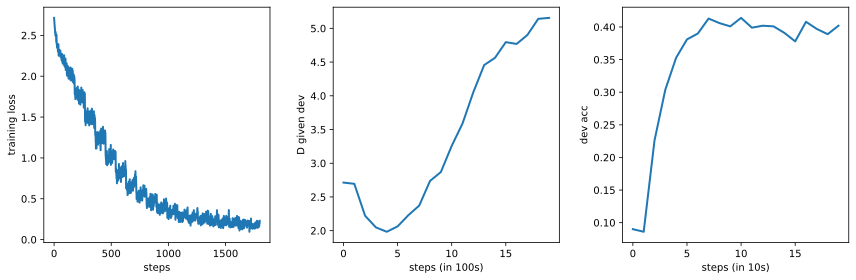

In [42]:
# Now let's train a model on this data.

# First, reset random number generators
seed_all()

# Use GPU acceleration
my_device = torch.device('cuda:0')

# Create the model
model = CategoricalModel(
    support_size=len(brown.categories()),
    hidden_size=32,
    encoder=TextEncoder(
        vocab_size=len(cat_vocab),
        word_embed_dim=100,
        hidden_size=64,
        reduce_mean=True,
        pad_id=cat_vocab.pad_id
    ), 
    p_drop=0.1
).to(my_device)

# Construct an Adam optimiser
optimiser = opt.Adam(model.parameters(), lr=5e-3)

print("Model")
print(model)

# Report number of parameters
print(f"Model size: {model.num_parameters():,} parameters")

# Train the model
log = train_neural_model(
    model, optimiser, 
    decision_rule=ExactMode(),
    training_data=TextRegressionCorpus(cat_training_x, cat_training_y, cat_vocab), 
    dev_data=TextRegressionCorpus(cat_dev_x, cat_dev_y, cat_vocab),
    report_fn=report_classification,
    report_metrics=['accuracy'],
    batch_size=500, num_epochs=20, check_every=100,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['D'])), log['D'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('D given dev')
_ = axs[2].plot(np.arange(len(log['accuracy'])), log['accuracy'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

Let's use the model for some predictions.

In [43]:
# Set up the test dataloader
cat_test_corpus = TextRegressionCorpus(cat_test_x, cat_test_y, cat_vocab)
cat_test_dl = DataLoader(cat_test_corpus, batch_size=3, shuffle=True, collate_fn=cat_test_corpus.pad_to_longest)
batch_x, batch_y = next(iter(cat_test_dl))

# Use the mode to form predictions.
decision_rule = ExactMode()
predictions = decision_rule(model, batch_x.to(my_device))

for x, pred, truth in zip(batch_x, batch_y, predictions):
    print(f"input: {' '.join(cat_vocab.decode(x, strip_pad=True))}")
    print(f"prediction: {brown.categories()[pred]}")
    print(f"truth: {brown.categories()[truth]}")
    print()

input: Have you examined this problem of increasing consumer sophistication from the standpoint of your own company ? ? -EOS-
prediction: hobbies
truth: lore

input: Some have plenty of money -- some have very little money . -EOS-
prediction: lore
truth: mystery

input: Thus far the advances made have been almost entirely along functional lines . -EOS-
prediction: belles_lettres
truth: learned



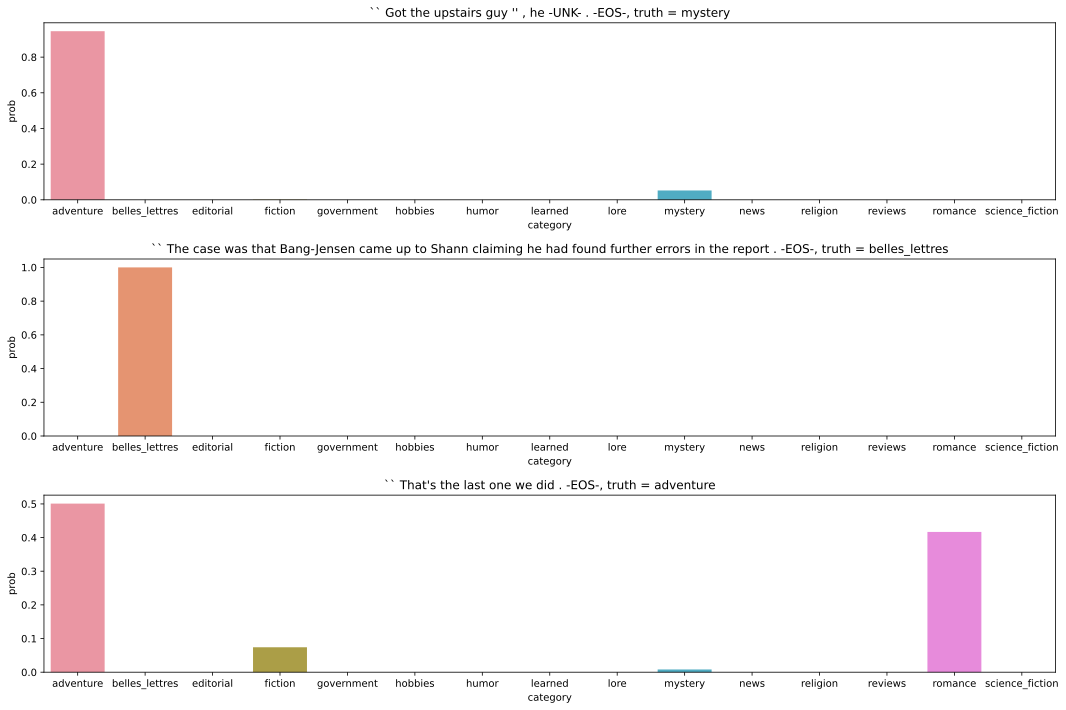

In [44]:
# We can also visualize the predicted Categoricals and use them for sampling or input
# to any arbitrary decision rule.
import seaborn as sns
import pandas as pd

with torch.no_grad():
    batch_x, batch_y = next(iter(cat_test_dl))
    cpds = model(batch_x.to(my_device))

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
for ax, x, y, predicted_probs in zip(axes, batch_x, batch_y, cpds.probs):
    sns.barplot(data=pd.DataFrame({"category": brown.categories(), "prob": predicted_probs.cpu()}),
                x="category", y="prob", ax=ax)
    ax.set_title(f"{' '.join(cat_vocab.decode(x, strip_pad=True))}, truth = {brown.categories()[y]}")

plt.tight_layout()
plt.show()

### 7.2 Poisson

Here we design a probabilistic model for an ordinal response variable $Y$ given a document $x$, for which we choose to model with a Poisson pmf:

\begin{align}
Y|X=x &\sim \mathrm{Poisson}(g(x; \theta)) \\
\mathbf u &= \mathrm{encode}_D(x; \theta_{\text{enc}}) \\
s &= \mathrm{affine}_1(\mathbf u; \theta_{\text{out}}) \\
g(x; \theta) &= \mathrm{softplus}(s)
\end{align}

The Poisson rate parameter must be strictly positive, thus we use a softplus output.


In [45]:
class PoissonModel(Model):
    """
    This model predicts a conditional Poisson distribution Y|X=x for ordinal data.
    """

    def __init__(self, hidden_size: int, encoder: Encoder, p_drop=0.):
        super().__init__(tuple())
        self.encoder = encoder
        self.hidden_size = hidden_size

        # The poisson distribution has 1 parameter: its rate. This needs to be a positive real number.
        self.rate_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(encoder.output_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, 1),
            nn.Softplus()
        )
        
    def forward(self, x):        
        h = self.encoder(x)
        rate = self.rate_predictor(h)
        return td.Poisson(rate=rate) 

    def sample(self, x, sample_size=tuple()):
        with torch.no_grad():
            cpd = self(x=x)
            return cpd.sample(sample_size)

    def mode(self, x):
        with torch.no_grad():
            cpd = self(x=x)
            rate = cpd.rate
            return torch.floor(rate)

22,734 words in the vocabulary.
Model
PoissonModel(
  (encoder): TextEncoder(
    (word_embed): Embedding(83532, 100)
    (encoder): LSTM(100, 64, batch_first=True, bidirectional=True)
  )
  (rate_predictor): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features=32, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Softplus(beta=1, threshold=20)
  )
)
Model size: 8,442,353 parameters


  0%|          | 0/400 [00:00<?, ?it/s]

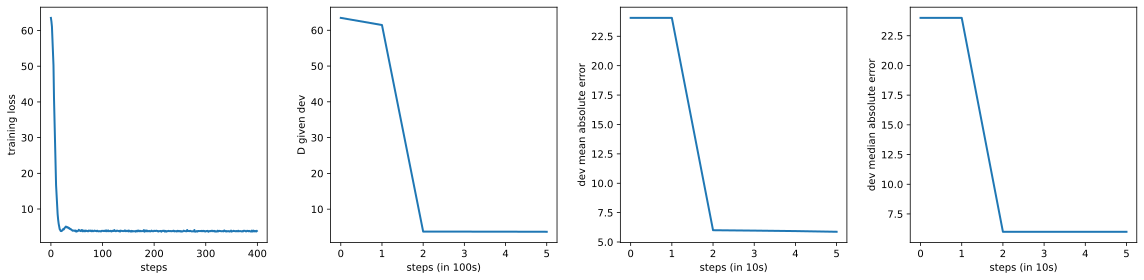

In [46]:
# Let's train on the age data using a conditional Poisson model.

# We need to construct the vocabulary for this data.
blog_vocab = Vocab(blog_training_x, min_freq=2)
print(f"{len(cat_vocab):,} words in the vocabulary.")

# Reset the random seeds
seed_all()

# Use GPU acceleration
my_device = torch.device('cuda:0')

# Create a similar model as before, but predicting a Poisson distribution instead.
model = PoissonModel(
    hidden_size=32,
    encoder=TextEncoder(
        vocab_size=len(blog_vocab),
        word_embed_dim=100,
        hidden_size=64,
        reduce_mean=True, 
        pad_id=blog_vocab.pad_id
    ), 
    p_drop=0.1
).to(my_device)

# construct an Adam optimiser
optimiser = opt.Adam(model.parameters(), lr=5e-3)

print("Model")
print(model)

# Report number of parameters
print(f"Model size: {model.num_parameters():,} parameters")

# Train the model
log = train_neural_model(
    model, optimiser, 
    decision_rule=ExactMode(),
    training_data=TextRegressionCorpus(blog_training_x, blog_training_y, blog_vocab), 
    dev_data=TextRegressionCorpus(blog_dev_x, blog_dev_y, blog_vocab),
    report_fn=report_regression,
    report_metrics=["MSE", "MAE", "MdAE"],
    batch_size=500, num_epochs=1, check_every=100,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 4, sharey=False, figsize=(16, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['D'])), log['D'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('D given dev')
_ = axs[2].plot(np.arange(len(log['MAE'])), log['MAE'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev mean absolute error')
_ = axs[3].plot(np.arange(len(log['MdAE'])), log['MdAE'])
_ = axs[3].set_xlabel('steps (in 10s)')
_ = axs[3].set_ylabel('dev median absolute error')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

In [47]:
# Set up the test dataloader
blog_test_corpus = TextRegressionCorpus(blog_test_x, blog_test_y, blog_vocab)
blog_test_dl = DataLoader(blog_test_corpus, batch_size=3, shuffle=True, collate_fn=blog_test_corpus.pad_to_longest)
batch_x, batch_y = next(iter(blog_test_dl))

# We can use the mode again to form predictions.
decision_rule = ExactMode()
predictions = decision_rule(model, batch_x.to(my_device))

for x, pred, truth in zip(batch_x, batch_y, predictions):
    print(f"input: {' '.join(blog_vocab.decode(x, strip_pad=True))}")
    print(f"prediction: {pred.item()}")
    print(f"truth: {truth.item()}")
    print()

input: every day deserves a good urllink insult . but , no one insults like shakespeare ... : drunkenness is his best virtue , for he will be swine drunk , and in his sleep he does little harm , save to his -UNK- about him . -EOS-
prediction: 26
truth: 24.0

input: here 's something i never thought i 'd never see : an epa ad mocking the idea of good fuel -UNK- in cars . urllink http : -UNK- maybe the appliance department should talk to the transportation department and get everyone on the same page . -EOS-
prediction: 17
truth: 24.0

input: i ca n't tolerate bitches ... im just allergic to them . they have no quality in starting a conversation and worse of all , a disgrace to women around the world . its in me ... i ca n't tolerate them . heard of a saying , respect yourself ... before others respect you .. very the true ... -EOS-
prediction: 24
truth: 24.0



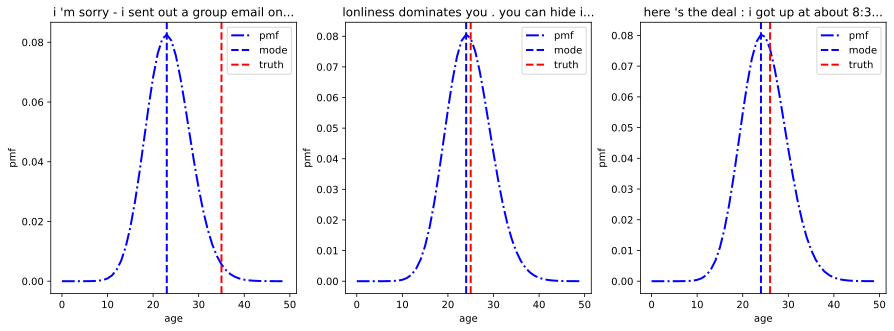

In [48]:
# We can also visualize the pmf of the predicted conditional Poisson distributions.
with torch.no_grad():
    batch_x, batch_y = next(iter(blog_test_dl))
    cpds = model(batch_x.to(my_device))
    mode = model.mode(batch_x.to(my_device))
    
x = torch.arange(0, 50).repeat(3, 1)
pmf = cpds.log_prob(x.to(my_device)).exp()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(x[i].cpu(), pmf[i].cpu().numpy(), ls='-.', color='b', label='pmf')
    axes[i].axvline(mode[i].cpu().numpy(), ls="--", color='b', label='mode')
    axes[i].axvline(batch_y[i].numpy(), color='r', ls='--', label='truth')
    axes[i].set_xlabel("age")
    axes[i].set_ylabel("pmf")
    axes[i].set_title(f"{' '.join(blog_vocab.decode(batch_x[i], strip_pad=True))[:40]}...")
    axes[i].legend()

### 7.3 Sequence labelling

In sequence labelling we have two sequences of equal length: a word sequence $x_{1:l}$ and a tag sequence $y_{1:l}$.


The word sequence $x_{1:l} = \langle x_1, \ldots, x_l \rangle$, where $l$ is the sequence length, is such that token $x_i$ belongs to a vocabulary $\mathcal W$ of $V$ known words. 

The tag sequence $y_{1:l} = \langle y_1, \ldots, y_l \rangle$, where $l$ is the same length as the document $x_{1:l}$, is such that each tag $y_i$ belongs to a vocabulary $\mathcal T$ of $C$ known tags.

As always, our models are probability distributions, but this time we need a distribution over a space of sequences. A sequence is a finite length object, but it cannot be seen as a fixed dimensional vector (a multivariate random variable), for its length is not at all fixed. A sequence is best seen as a data structure. To prescribe a distribution over a general data structure, we can decompose this structure into parts, prescribe distributions for the parts, and combine them into a single pdf. 

Chain rule allows us to re-express a pdf over an arbitrary sample space (with multivariate or structured outcomes) as a product of pdfs, each over a simpler space space (e.g., with univariate outcomes):

\begin{align}
p(y_{1:l}|x_{1:l}, \theta) &= \prod_{i=1}^l p(y_i|x_{1:l}, y_1^{i-1}, \theta) \\
&=  \prod_{i=1}^l \mathrm{Categorical}(y_i|\mathbf g(x_{1:l}, y_1^{i-1}; \theta))
\end{align}



where, on the right-hand side of the first equation, we have pdfs (or pfms) for each step of the sequence. In the second row, we use a Categorical pmf since each step of the sequence is a simple categorical variable. Each pmf is parameterised in context using some trainable function $\mathbf g$ with parameters $\theta$.

The above is a *factorisation* of the joint pdf. This is one valid factorisation, and this one does not make any conditional independence assumptions (i.e., it conditions on all parts of the structure already generated). We could simplify the factorisation by making such conditional independence (or Markov) assumptions. For example, we might use only $x_{1:l}$ and the previous step $y_{i-1}$ when parameterising the distribution of $Y_i$. These assumptions are justified on a case by case basis depending on application domain. 


In [49]:
class Tagger(Model):

    def __init__(self, vocab_size: int, tagset_size: int, pad_id=0, bos_id=1, eos_id=2):
        super().__init__()
        self._vocab_size = vocab_size
        self._tagset_size = tagset_size
        self._pad = pad_id
        self._bos = bos_id
        self._eos = eos_id

    @property
    def vocab_size(self):
        return self._vocab_size

    @property
    def tagset_size(self):
        return self._tagset_size

    @property
    def pad(self):
        return self._pad

    @property
    def bos(self):
        return self._bos

    @property
    def eos(self):
        return self._eos

    def num_parameters(self):
        return sum(np.prod(theta.shape) for theta in self.parameters())
        
    def forward(self, x, y_in):
        """
        To predict the distribution of Y[i], an autoregressive model conditions
         on both x and y[:i]. Normally, y_in is prepended with some BOS code so
         that both sequences have the same length.

        x: [batch_size, max_length]
        y_in: [batch_size, max_length]

        Return a batch of cpds, one per step.
        """
        raise NotImplementedError("Each type of tagger will have a different implementation here")

    def log_prob(self, x, y):
        """
        Computes the log conditional probability of each tag sequence in a batch.

        x: [batch_size, max_length]
        y: [batch_size, max_length]
        """
        # shift the output sequence and prepend the BOS code
        # (after all, we do not want to condition on what we need to predict)
        batch_size, max_len = y.shape
        bos = torch.full((batch_size, 1), self.bos, device=y.device)
        y_in = torch.cat([bos, y], 1)[:,:-1]
        
        # one C-dimensional Categorical cpd for each token in the batch
        cpds = self(x=x, y_in=y_in)
        # [batch_size, max_length]        
        logp = cpds.log_prob(y)
        # [batch_size]
        logp = torch.where(y != self.pad, logp, torch.zeros_like(logp)).sum(-1)
        return logp  

    def greedy(self, x):
        """
        For each cpd Y[i]|X=x, predicts the mode of the cpd.
        x: [batch_size, max_length]

        Return: tag sequences [batch_size, max_length]
        """
        raise NotImplementedError("Each type of tagger differs here")

    def sample(self, x, sample_size=tuple()):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        x: [batch_size, max_len]

        Return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """
        raise NotImplementedError("Each type of tagger differs here")

In [50]:
# we get a vocabulary for words
word_vocab = Vocab(tagger_training_x, min_freq=2)
# and a vocabulary for tags
tag_vocab = Vocab(tagger_training_y, min_freq=1)
# you can see their sizes V and C:
len(word_vocab), len(tag_vocab)

(3358, 16)

#### 7.3.1 Independent C-way classification

Our first tagger is in fact just a $C$-way classifier that we use to predict a distribution over $C$ tags for different positions of an input sequence conditioned on the entire input sequence.

Here is the model of the $i$th tag given $x_{1:l}$:
\begin{align}
Y_i | S=x_{1:l} &\sim \mathrm{Categorical}(\mathbf g(i, x_{1:l}; \theta))
\end{align}

where $\mathbf g$ is a neural network. For example:
\begin{align}
\mathbf e_j &= \mathrm{embed}_D(x_j; \theta_{\text{in}})  & j \in \{1, \ldots, l\}\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf s_i &= \mathrm{affine}_C(\mathbf u_i; \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

The bidirection RNN layer concatenates the states of two independent RNN layers, one that processes the sequence from left-to-right, another that processes it from right-to-left. 

Note how this model ignores every other tag in the sequence.

In [51]:
class BasicTagger(Tagger):

    def __init__(self, vocab_size, tagset_size, word_embed_dim: int, hidden_size: int, p_drop=0, pad_id=0, bos_id=1, eos_id=2):
        """        
        vocab_size: number of known words
        tagset_size: number of known tags
        word_embed_dim: dimensionality of word embeddings
        hidden_size: dimensionality of hidden layers
        recurrent_encoder: enable recurrent encoder
        bidirectional_encoder: for a recurrent encoder, make it bidirectional
        """
        super().__init__(vocab_size=vocab_size, tagset_size=tagset_size, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id)
        self.word_embed_dim = word_embed_dim
        self.hidden_size = hidden_size        
        self.encoder = TextEncoder(
            vocab_size=vocab_size,
            word_embed_dim=word_embed_dim,
            hidden_size=hidden_size,
            reduce_mean=False,
            pad_id=pad_id,
            p_drop=p_drop
        )
        # the bidirectional LSTM encoder produces outputs of size 2*hidden_size
        # thus our linear layer must take 2*hidden_size inputs
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(self.encoder.output_dim, self.tagset_size)
        )
        
    def forward(self, x, y_in=None):
        """
        Parameterise the conditional distributions over Y[i] given the entire word sequence x.        

        x: [batch_size, max_length]
        y: not used by this class

        Return: a batch of C-dimensional Categorical distributions, one per step of the sequence.
        """
        # We begin by encoding the tokens 
        # [batch_size, max_length, enc_dim]
        h = self.encoder(x)
        # finally, per step of the sequence we predict logits for the possible tags
        # [batch_size, max_length, tagset_size]        
        s = self.logits_predictor(h)
        # and convert those logits to Categorical distributions
        return td.Categorical(logits=s)

    def greedy(self, x):
        """
        For each cpd Y[i]|X=x, predicts the mode of the cpd.
        x: [batch_size, max_length]

        Return: tag sequences [batch_size, max_length]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x)
            # [batch_size, max_length]
            y_pred = torch.argmax(cpds.probs, -1)
            # if a position in x is padded, it should be padded in y
            y_pred = torch.where(x != self.pad, y_pred, torch.zeros_like(y_pred) + self.pad)
            return y_pred

    def mode(self, x):
        return self.greedy(x)

    def sample(self, x, sample_size=None):
        """
        Per word sequence in the batch, draws a number of samples from the model, each sample is a complete tag sequence.

        x: [batch_size, max_len]

        Return: tag sequences with shape [batch_size, max_len] if sample_size is None
            else with shape [sample_size, batch_size, max_len]
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]
        with torch.no_grad():
            cpds = self(x)
            if sample_size is None:
                shape = (1,)
            else:
                shape = (sample_size,)
            # [sample_size, batch_size, max_length]
            y_pred = cpds.sample(shape)
            # if a position in x is padding, it must be padded in y too
            y_pred = torch.where(x.unsqueeze(0) != self.pad, y_pred, torch.zeros_like(y_pred) + self.pad)
            # takes care of output shape
            if sample_size is None:
                return y_pred.squeeze(0)
            else:
                return y_pred

In [52]:
def test_basic_tagger(training_x, training_y, vocab_x, vocab_y):
    seed_all()
    toy_uni_tagger = BasicTagger(
        vocab_size=len(vocab_x), 
        tagset_size=len(vocab_y), 
        word_embed_dim=32,
        hidden_size=32
    )    

    assert type(toy_uni_tagger(torch.from_numpy(vocab_x.batch_encode(training_x[:2])))) is td.Categorical

    assert toy_uni_tagger.log_prob(
            torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 
            torch.from_numpy(vocab_y.batch_encode(training_y[:2]))
        ).shape == (2,)

    assert loss(toy_uni_tagger,
            torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 
            torch.from_numpy(vocab_y.batch_encode(training_y[:2]))
        ).shape == tuple()

    assert toy_uni_tagger.sample(torch.from_numpy(vocab_x.batch_encode(training_x[:2]))).shape == vocab_x.batch_encode(training_x[:2]).shape

    assert toy_uni_tagger.sample(torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 3).shape == (3,) + vocab_x.batch_encode(training_x[:2]).shape

    assert toy_uni_tagger.greedy(torch.from_numpy(vocab_x.batch_encode(training_x[:2]))).shape == vocab_x.batch_encode(training_x[:2]).shape
    

test_basic_tagger(tagger_training_x, tagger_training_y, word_vocab, tag_vocab)


#### 7.3.2 Autoregressive tagger 

When predicting the distribution of $Y_i$, an autoregressive tagger conditions on the tag sequence already generated thus far, hence it makes no Markov assumption. This is the model of the $i$th tag:

\begin{align}
Y_i | S=x_{1:l}, H=y_1^{i-1} &\sim \mathrm{Categorical}(\mathbf g(i, x_{1:l}, y_1^{i-1}; \theta))
\end{align}

where $\mathbf g$ is a neural network. For example:

\begin{align}
\mathbf e_j &= \mathrm{embed}_{D_1}(x_j; \theta_{\text{words}}) & j \in \{1, \ldots, l\}\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k < i\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf v_i &= \mathrm{rnnstep}_K(\mathbf v_{i-1},  \mathbf t_{i-1}; \theta_{\text{dec}})\\
\mathbf s_i &= \mathrm{ffnn}_C(\mathrm{concat}(\mathbf u_i, \mathbf v_i); \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

Again, we  have two different embedding layers, one for words and one for tags. 
Again, we use a bidirectional rnn to encode the whole document. 
Now, for the $i$th position, we use an RNN generator/decoder cell to encode the complete history of previous tags. We then predict the logits by using an FFNN to combine the history encoding with the document encoding for position $i$.

There's yet another way to parameterise this model, in which we let the RNN decoder compose the features of the history with the features of the document:

\begin{align}
\mathbf e_j &= \mathrm{embed}_{D_1}(x_j; \theta_{\text{words}}) & j \in \{1, \ldots, l\}\\
\mathbf t_k &= \mathrm{embed}_{D_2}(y_k; \theta_{\text{tags}}) & k < i\\
\mathbf u_{1:l} &= \mathrm{birnn}_{2K}(\mathbf e_{1:l}; \theta_{\text{bienc}})\\
\mathbf v_i &= \mathrm{rnnstep}_K(\mathbf v_{i-1}, \mathrm{concat}(\mathbf u_i, \mathbf t_{i-1}); \theta_{\text{dec}})\\
\mathbf s_i &= \mathrm{affine}_C(\mathbf v_i; \theta_{\text{out}})\\
\mathbf g(i, x_{1:l}) &= \mathrm{softmax}(\mathbf s_i)
\end{align}

Both are very good options.

In [53]:
class AutoregressiveTagger(Tagger):

    def __init__(self, vocab_size: int, tagset_size: int, word_embed_dim: int, tag_embed_dim: int, hidden_size: int, p_drop=0., pad_id=0, bos_id=1, eos_id=2):
        """
        ngram_size: longest ngram (for tag sequence)
        vocab_size: number of known words
        tagset_size: number of known tags
        word_embed_dim: dimensionality of word embeddings
        tag_embed_dim: dimensionality of tag embeddings (needed to encode the history of ngram_size-1 tags)
        hidden_size: dimensionality of hidden layers
        """
        super().__init__(vocab_size=vocab_size, tagset_size=tagset_size, pad_id=pad_id, bos_id=bos_id, eos_id=eos_id)        
        self.word_embed_dim = word_embed_dim
        self.tag_embed_dim = tag_embed_dim
        self.hidden_size = hidden_size

        self.encoder = TextEncoder(
            vocab_size=vocab_size,
            word_embed_dim=word_embed_dim,
            hidden_size=hidden_size,
            reduce_mean=False,
            pad_id=pad_id
        )
        # we need to embed tags in the history 
        self.tag_embed = nn.Embedding(tagset_size, embedding_dim=tag_embed_dim) 
        
        self.decoder = nn.LSTM(
            input_size=tag_embed_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        # for each position i, we need to combine the encoding of x[i] in context 
        # as well as the history of ngram_size-1 tags
        # so we use a FFNN for that:
        self.logits_predictor = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(self.encoder.output_dim + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_size, tagset_size),
        ) 

        self.init_state = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(self.encoder.output_dim, hidden_size),
            nn.Tanh()
        )
        self.init_cell = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(self.encoder.output_dim, hidden_size),
            nn.Tanh()
        )
                
    def forward(self, x, y_in):
        """
        Parameterise the conditional distributions over Y[i] given history y[:i] and all of x.

        This procedure takes care that the ith output distribution conditions only on the n-1 observations before y[i].
        It also takes care of padding to the left with BOS symbols.

        x: word sequences [batch_size, max_length]
        y_in: history of tag sequences  [batch_size, max_length]

        Return: a batch of V-dimensional Categorical distributions, one per step of the sequence.
        """

        # Let's start by encoding the conditioning sequences        
        # [batch_size, max_length, enc_dim]
        u = self.encoder(x)        
        
        # here we pad the tag sequence with BOS on the left
        # [batch_size, max_len, tag_emb_dim]
        t_in = self.tag_embed(y_in)

        # encode the histories
        # [batch_size, max_len, hidden_size]
        v, _ = self.decoder(t_in)
    
        # Now we can combine the encodings of x and the encodings of histories, we do so via concatenation
        # since there's a fixed number of such encodings per step of the sequence
        # [batch_size, max_length, 3*hidden_size]
        u = torch.cat([u, v], -1)
        # We are now ready to map the state of each step of the sequence to a C-dimensional vector of logits
        # we do so using our FFNN
        # [batch_size, max_length, tagset_size]
        s = self.logits_predictor(u)

        return td.Categorical(logits=s)

    def greedy(self,x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length + 1), self.bos, device=self.tag_embed.weight.device) 
            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # [batch_size, max_len, C] 
                cpds = self(x=x, y_in=y[:,:-1])
                # we get their modes via argmax
                # [batch_size, max_len]
                modes = torch.argmax(cpds.probs, -1)
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i+1] = modes[:, i]     
            # discard the BOS token
            y = y[:,1:]           
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)
            
            return y

    def mode(self, x):
        raise NotImplementedError("The search for the mode of the autoregressive tagger is intractable, consider using `greedy` or a sampling-based approximation. ")

    def _sample(self, x):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        batch_size = x.shape[0]
        max_length = x.shape[1]

        with torch.no_grad():
            # add the beginning we do not know the tag sequence
            # but NNs work with fixed dimensional tensors, 
            # so we allocate a tensor full of BOS codes
            y = torch.full((batch_size, max_length + 1), self.bos, device=self.tag_embed.weight.device) 

            # Per step
            for i in range(max_length):
                # we parameterise a cpd for Y[i]|X=x
                # note that the forward method takes care of not conditioning on y[i] itself
                # and only using the ngram_size-1 previous tags
                # at this point, the tag y[i] is a dummy code
                # the forward method recomputes all cds in the batch, this will include the cpd for Y[i]
                # we get their modes via argmax
                # [batch_size, max_len, C]
                cpds = self(x=x, y_in=y[:,:-1])
                # [batch_size, max_len]
                samples = cpds.sample()
                
                # Here we update the current token to the freshly obtained mode
                #  and also replace the token by 0 (pad) in case the sentence is already complete
                y[:, i+1] = samples[:,i]
            # discard the BOS token
            y = y[:,1:]
            # where we had a PAD token in x, we change the y token to PAD too
            y = torch.where(x != self.pad, y, torch.zeros_like(y) + self.pad)

            return y

    def sample(self, x, sample_size=None):
        """
        Draws a number of samples from the model, each sample is a complete sequence.
        We impose a maximum number of steps, to avoid infinite loops.
        This procedure takes care of mapping sampled symbols to pad after the EOS symbol is generated.
        """
        if sample_size is None:
            return self._sample(x)
        else:
            samples = [self._sample(x) for _ in range(sample_size)]
            return torch.stack(samples)

In [54]:
def test_autoreg_tagger(training_x, training_y, vocab_x, vocab_y):
    seed_all()
    toy_ar_tagger = AutoregressiveTagger(
        vocab_size=len(vocab_x), 
        tagset_size=len(vocab_y), 
        word_embed_dim=32,
        tag_embed_dim=16,
        hidden_size=32
    )    

    assert type(toy_ar_tagger(
        torch.from_numpy(vocab_x.batch_encode(training_x[:2])),
        torch.from_numpy(vocab_y.batch_encode(training_y[:2])))
    ) is td.Categorical

    assert toy_ar_tagger.log_prob(
            torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 
            torch.from_numpy(vocab_y.batch_encode(training_y[:2]))
        ).shape == (2,)

    assert loss(toy_ar_tagger,
            torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 
            torch.from_numpy(vocab_y.batch_encode(training_y[:2]))
        ).shape == tuple()

    assert toy_ar_tagger.sample(torch.from_numpy(vocab_x.batch_encode(training_x[:2]))).shape == vocab_x.batch_encode(training_x[:2]).shape

    assert toy_ar_tagger.sample(torch.from_numpy(vocab_x.batch_encode(training_x[:2])), 3).shape == (3,) + vocab_x.batch_encode(training_x[:2]).shape

    assert toy_ar_tagger.greedy(torch.from_numpy(vocab_x.batch_encode(training_x[:2]))).shape == vocab_x.batch_encode(training_x[:2]).shape
    

test_autoreg_tagger(tagger_training_x, tagger_training_y, word_vocab, tag_vocab)

Because labelling is a chain of classification decisions, we can also evaluate our tagger in terms of accuracy of its decisions. For that we need a decision rule. Normally, in NLP, we use the most probable tag sequence as a decision. That is, given a sentence $x_{1:l}$ we search in the space $\{1, \ldots, C\}^l$ of all tag sequences of length $l$, for the one sequence that the model assigns highest probability to (i.e., the *mode* of the conditional distribution):

\begin{align}
y^\star &= \arg\max_{c_{1:l} \in \{1, \ldots, C\}^l}~ \log P(G=c_{1:l}|S=x_{1:l})
\end{align}

This search is defined over an extremely large space and is generally not tractable. For some types of tagger, because of their conditional independence assumptions, this search may be doable in polynomial time (as a function of sequence length), for others this is not at all possible. 

For the basic tagger, which treats the tags as independent given the sentence, this search can be done exactly, because greedily maximising each step independently is equivalently to maximising the joint assignment of the entire sequence for that model.

**Search for the unigram tagger**

We search for the best tag in each position, which takes time $\mathcal O(C)$ per position, 

\begin{align}
y^\star_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l})
\end{align}

and put them together in a sequence. The total operation takes time $\mathcal O(l \times C)$.

**Search for the autoregressive tagger**

The autoregressive tagger makes no conditional independence assumptions, and the search problem is genuinely intractable for this model. Being intractable means there is not efficient algorithm known to be able to handle it. In fact, the current hypothesis is that an efficient (by efficient we mean that it runs in polynomial time as a function of $l$) is actually impossible in standard computer architectures. Problems of this kind are called NP-complete.

For this tutorial, we will again use the greedy approximation:

\begin{align}
\hat y_i &= \arg\max_{c \in \{1, \ldots, C\}}~ \log P(Y_i=c|S=x_{1:l}, H=\hat y_1^{i-1})
\end{align}

where we solve the argmax locally per position in order from left-to-right. For each step $Y_i$ we condition on the already predicted argmax for all the preceding steps.


---

Once we have a search algorithm in place to make predictions we can compute accuracy and/or other metrics common for classification.


In [55]:
class GreedyMode(DecisionRule):

    def __call__(self, model, x):
        return model.greedy(x)    

On GPU, this should take just about 2 minutes:

Model
BasicTagger(
  (encoder): TextEncoder(
    (word_embed): Embedding(3358, 4)
    (encoder): LSTM(4, 8, batch_first=True, bidirectional=True)
  )
  (logits_predictor): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
)
Model size: 14,600 parameters


  0%|          | 0/2490 [00:00<?, ?it/s]

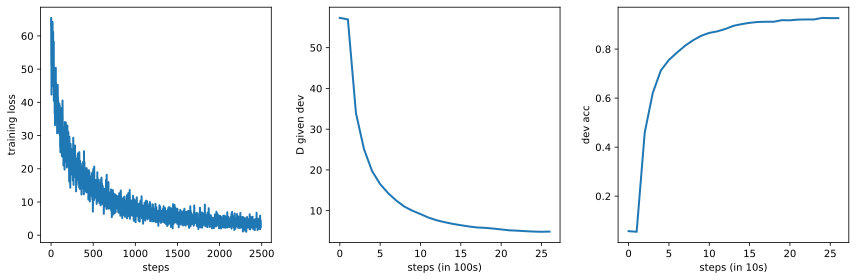

In [56]:
seed_all() # reset random number generators before creating your model and training it

my_device = torch.device('cuda:0')

tagger = BasicTagger(
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=4,
    hidden_size=8,
).to(my_device)


# construct an Adam optimiser
optimiser = opt.Adam(tagger.parameters(), lr=5e-3)

print("Model")
print(tagger)

# report number of parameters
print(f"Model size: {tagger.num_parameters():,} parameters")

# Train the model
log = train_neural_model(
    tagger, optimiser, 
    decision_rule=ExactMode(), 
    training_data=TaggedCorpus(tagger_training_x, tagger_training_y, word_vocab, tag_vocab), 
    dev_data=TaggedCorpus(tagger_dev_x, tagger_dev_y, word_vocab, tag_vocab), 
    report_fn=report_tagging, report_metrics=['accuracy'],
    batch_size=10, num_epochs=10, check_every=100,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['D'])), log['D'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('D given dev')
_ = axs[2].plot(np.arange(len(log['accuracy'])), log['accuracy'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

Model
AutoregressiveTagger(
  (encoder): TextEncoder(
    (word_embed): Embedding(3358, 4)
    (encoder): LSTM(4, 8, batch_first=True, bidirectional=True)
  )
  (tag_embed): Embedding(16, 4)
  (decoder): LSTM(4, 8, batch_first=True)
  (logits_predictor): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=24, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=8, out_features=16, bias=True)
  )
  (init_state): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Tanh()
  )
  (init_cell): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Tanh()
  )
)
Model size: 15,456 parameters


  0%|          | 0/2490 [00:00<?, ?it/s]

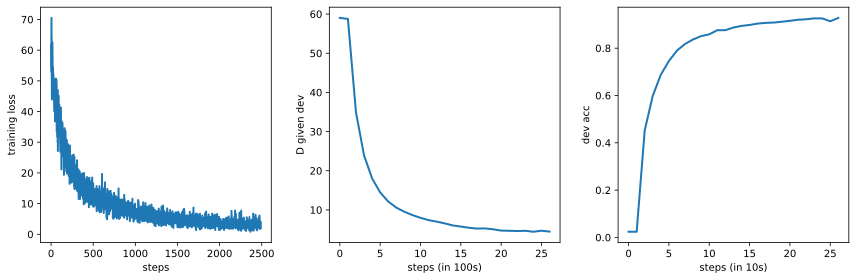

In [57]:
seed_all() # reset random number generators before creating your model and training it

my_device = torch.device('cuda:0')

ar_tagger = AutoregressiveTagger(
    vocab_size=len(word_vocab), 
    tagset_size=len(tag_vocab), 
    word_embed_dim=4,
    tag_embed_dim=4,
    hidden_size=8,
).to(my_device)


# construct an Adam optimiser
optimiser = opt.Adam(ar_tagger.parameters(), lr=5e-3)

print("Model")
print(ar_tagger)

# report number of parameters
print(f"Model size: {ar_tagger.num_parameters():,} parameters")

# Train the model
log = train_neural_model(
    ar_tagger, optimiser, 
    decision_rule=GreedyMode(), 
    training_data=TaggedCorpus(tagger_training_x, tagger_training_y, word_vocab, tag_vocab), 
    dev_data=TaggedCorpus(tagger_dev_x, tagger_dev_y, word_vocab, tag_vocab), 
    report_fn=report_tagging, report_metrics=['accuracy'],
    batch_size=10, num_epochs=10, check_every=100,
    device=my_device
)

# Plot loss and validation checks
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
_ = axs[0].plot(np.arange(len(log['loss'])), log['loss'])
_ = axs[0].set_xlabel('steps')
_ = axs[0].set_ylabel('training loss')
_ = axs[1].plot(np.arange(len(log['D'])), log['D'])
_ = axs[1].set_xlabel('steps (in 100s)')
_ = axs[1].set_ylabel('D given dev')
_ = axs[2].plot(np.arange(len(log['accuracy'])), log['accuracy'])
_ = axs[2].set_xlabel('steps (in 10s)')
_ = axs[2].set_ylabel('dev acc')
_ = fig.tight_layout(h_pad=2, w_pad=2)
plt.show()

In [58]:
tagger_dev_data = TaggedCorpus(tagger_dev_x, tagger_dev_y, word_vocab, tag_vocab)
tagger_dev_dl = DataLoader(tagger_dev_data, batch_size=1, shuffle=False, collate_fn=tagger_dev_data.pad_to_longest)
for batch_x, batch_y in tagger_dev_dl:
    print("Sample")
    y_out = ar_tagger.sample(batch_x.to(my_device))    
    
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(y_out, strip_pad=False)):
        print(" ".join(f"{w}/{t}" for w, t in zip(x, y)))
        
    print("\nGreedy")
    
    y_out = ar_tagger.greedy(batch_x.to(my_device))    
    
    for x, y in zip(word_vocab.batch_decode(batch_x, strip_pad=True), tag_vocab.batch_decode(y_out, strip_pad=False)):
        print(" ".join(f"{w}/{t}" for w, t in zip(x, y)))
    
    break

Sample
-UNK-/NOUN ,/. a/DET -UNK-/NOUN -UNK-/VERB the/DET -UNK-/NOUN of/ADP -UNK-/ADJ -UNK-/NOUN ,/. is/VERB marketed/VERB *-1/X as/ADP a/DET $/. -UNK-/NUM *u*/X -UNK-/VERB for/ADP -UNK-/ADJ -UNK-/NOUN ./. -EOS-/-EOS-

Greedy
-UNK-/NOUN ,/. a/DET -UNK-/NOUN -UNK-/VERB the/DET -UNK-/NOUN of/ADP -UNK-/ADJ -UNK-/NOUN ,/. is/VERB marketed/VERB *-1/X as/ADP a/DET $/. -UNK-/NUM *u*/X -UNK-/VERB for/ADP -UNK-/NOUN -UNK-/NOUN ./. -EOS-/-EOS-


## 8. Exercise: design your own deep probabilistic model (optional, non-graded)

Now it's time to design your own probabilistic model. The objective is to find a dataset and design a probabilistic model for it, parameterised by a neural network. Be conscious about the distributions you choose to model your data with, make sure they are appropriate for the data! Use maximum likelihood estimation for estimating neural network parameters. Also, be conscious about the decision rule you use. Can you obtain the mode exactly and is it appropriate under your model? Is there perhaps another criterion more sensible? Can you think of a way to use maximisation of expected utility for your model? As we have already provided many helper classes for learning features from text data, we encourage you to look into textual datasets, but note the data you are modelling can still be of any domain: ordinal, real numbers, discrete, structured, etc. Some good places to look for such data are:

* NLTK: https://www.nltk.org/nltk_data/
* HuggingFace: https://huggingface.co/datasets
* Kaggle: https://www.kaggle.com/datasets


Remarks on other types of data:

* some structured data are fixed-dimensional (e.g., an image of size HxWxC), some models are built upon a chain rule factorisation just like the sequence labeller above, but their parameterisation might exploit the fact that the dimensionality is fixed (a good example is a [MADE](https://arxiv.org/abs/1502.03509), you can ask Wilker more about those);
* some structured data are made of continuous parts (e.g., a time series in the finance domain, or in medical applications), in those cases your conditional factors are from a numerical family (e.g., Poisson, Normal, Gamma, etc), sometimes you need a distribution more powerful than the typical unimodal exponential family, in those cases you can use a mixture Model (we discuss those in the second module in the series) or a [normalising flow](https://arxiv.org/abs/1912.02762) (you can ask Wilker more about those, but note that Stratis will discuss NFs along with other advanced generative models)